In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle
import copy

!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm
!pip install line_profiler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
from sklearn.model_selection import train_test_split


# assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

     |████████████████████████████████| 71kB 2.2MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# # Used to load in the original images
# folder = './drive/My Drive/BYU/Boggle Project'
# letter_dict_file = os.path.join(folder, 'letter_dict.pkl')
# with open(letter_dict_file, 'rb') as file:
#     letter_dict = pickle.load(file)

In [0]:
# Define our Boggle Dataset class
class BoggleDataset(Dataset):
    def __init__(self, root='./drive/My Drive/BYU/Boggle Project', size=128, train=True):
        # Initialize input variables, load the full dataset
        self.__dict__.update(locals())
        dataset_folder = os.path.join(self.root, 'boggle_dataset')
        self.transformations = transforms.Compose([transforms.Resize(self.size), transforms.Grayscale(), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
        self.full_dataset = torchvision.datasets.ImageFolder(root=dataset_folder, transform=self.transformations)

        # Split the data into train and test 
        train_X, test_X, train_y, test_y = train_test_split(range(len(self.full_dataset)), self.full_dataset.targets, train_size=0.7, test_size=0.3, random_state=9)
        if self.train: self.dataset = torch.utils.data.Subset(self.full_dataset,train_X) 
        else: self.dataset = torch.utils.data.Subset(self.full_dataset,test_X)

    def __getitem__(self,index):
        img = self.dataset[index][0]
        label = self.dataset[index][1] # Labels are 0-25, which correspond to A-Z.
        return img,label
  
    def __len__(self):
        return len(self.dataset)

In [0]:
# Define our Model Architecture:
class BoggleNet(nn.Module):
    def __init__(self, input_channels=1, output_channels=26):
        super(BoggleNet, self).__init__()
        # Input Size: b x 1 x 128 x 128
        self.ConvBlock1 = nn.Sequential(nn.Conv2d(input_channels, 32, kernel_size=(3,3), stride=1),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(32),
                                        nn.Conv2d(32, 64, kernel_size=(3,3)),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(64),
                                        nn.Conv2d(64, 128, kernel_size=(3,3)),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(128),
                                        nn.Dropout(p=0.1))
        
        self.ConvBlock2 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=(2,2), stride=2, padding=(0,0)), # Learn the best max pooling layer using an convolution layer
                                        nn.ReLU(),
                                        nn.BatchNorm2d(64),
                                        nn.Dropout(p=0.1),
                                        nn.Conv2d(64, 32, kernel_size=(2,2), stride=2, padding=(0,0)),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(32),
                                        nn.Dropout(p=0.1),
                                        nn.Conv2d(32, 16, kernel_size=(2,2), stride=2, padding=(0,0)),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(16))

        self.FullyConnected1 = nn.Sequential(nn.Linear(15, 16*15),
                                             nn.ReLU(),
                                             nn.Linear(16*15,16),
                                             nn.Flatten(),
                                             nn.Linear(15*16*16, output_channels))
                                            #  nn.Softmax(1))
                                            
        # self.test_layer = nn.Sequential(nn.Flatten(),
                                        # nn.Linear(128*128, output_channels),
                                        # nn.Softmax(1))

        # self.ConvBlock = nn.Sequential(nn.Conv2d(input_channels, 32, kernel_size=(3,3), stride=1),   # Convolutional Layer
        #                                nn.ReLU(),                                                    # Activation 
        #                                nn.BatchNorm2d(32),                                           # Batch Norm
        #                                nn.Conv2d(32,32, kernel_size=(2,2), stride=2, padding=(0,0)),  # Learned Maxpool layer
        #                                nn.Conv2d(32,32, kernel_size=(3,3), stride=1),                # Convolutional Layer
        #                                nn.ReLU(),                                                    # Activation
        #                                nn.BatchNorm2d(32),                                           # Batch Norm
        #                                nn.Conv2d(32,32, kernel_size=(2,2), stride=2, padding=(0,0)),  # Learned Maxpool layer
        #                             #    nn.Dropout(p=0.3),
        #                                nn.Flatten(),
        #                                nn.Linear(32*30*30, 256),
        #                                nn.ReLU(),
        #                             #    nn.BatchNorm2d(32),                                           # Batch Norm
        #                                nn.Linear(256,output_channels),
        #                                nn.Softmax(1))
            
    def forward(self, x):
        x = self.ConvBlock1(x)
        x = self.ConvBlock2(x)
        x = self.FullyConnected1(x)
        # x = self.ConvBlock(x)
        return x

In [0]:
# # Initialize our Datasets, and DataLoaders
# all_data = BoggleDataset()
train_data = BoggleDataset(train=True)
test_data = BoggleDataset(train=False)

# # # Split the data into train and test 
# train_X, test_X, train_y, test_y = train_test_split(range(len(all_data)), all_data.dataset.targets, train_size=0.7, test_size=0.3, random_state=9)
# train_data = torch.utils.data.Subset(all_data,train_X) 
# test_data = torch.utils.data.Subset(all_data,test_X)

TrainLoader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True, num_workers = 16)
TestLoader = DataLoader(test_data, batch_size=16, shuffle=True, pin_memory=True, num_workers = 16)

In [0]:
def train_model(epochs=30, lr=0.001, retrain_model=True, model=None):
    # Initialize our Model
    if retrain_model or model is None:
        model = BoggleNet()
    model = model.cuda()

    # Initialize our Loss Function and Optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Our Main Training Loop
    loop = tqdm(range(len(TrainLoader)*epochs), position=0)
    overall_train_loss = []
    overall_train_accuracy = []
    for epoch in range(epochs):
        batch_loss = []
        batch_accuracy = []
        for i, (x, y_truth), in enumerate(TrainLoader):
            x, y_truth = x.cuda(), y_truth.cuda()
            optimizer.zero_grad()
            y_hat = model(x)
            
            # Compute and store the loss of our current network
            loss = loss_function(y_hat, y_truth)
            batch_loss.append(loss.item())

            #Compute and store the accuracy of our current network
            accuracy = (y_hat.argmax(1) == y_truth).float().mean()
            batch_accuracy.append(accuracy.item())

            # Update the weights and step in the directions of the new parameter values
            loss.backward()
            optimizer.step()

            # if i % 20 == 0:
            loop.set_description('Epoch:{}, Batch: {}, Loss:{:.4f}, Accuracy:{:.3f}'.format(epoch + 1, i+1,  batch_loss[-1], batch_accuracy[-1]))
            loop.update(1)
        # After each epoch, collect the average loss & accuracy for the epoch.
        overall_train_loss.append(np.mean(batch_loss))
        overall_train_accuracy.append(np.mean(batch_accuracy))
    
    return overall_train_loss, overall_train_accuracy, batch_loss, batch_accuracy, model

In [0]:
TrainLoader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True, num_workers = 16)
TestLoader = DataLoader(test_data, batch_size=32, shuffle=True, pin_memory=True, num_workers = 16)

overall_train_loss, overall_train_accuracy, batch_loss, batch_accuracy, model = train_model(epochs=10)

Epoch:10, Batch: 854, Loss:0.0493, Accuracy:1.000: 100%|██████████| 8540/8540 [24:01<00:00,  6.82it/s]

In [0]:
weights_filename = './drive/My Drive/BYU/Boggle Project/boggleNet_weights.pth'
torch.save(model.state_dict(),weights_filename)

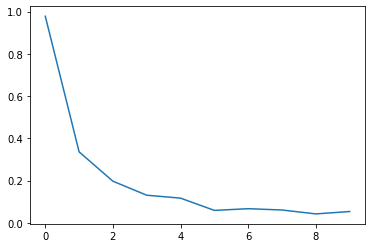

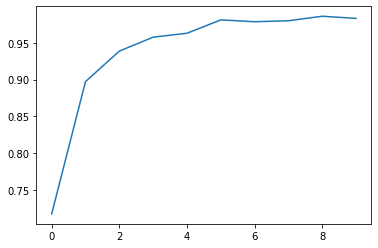

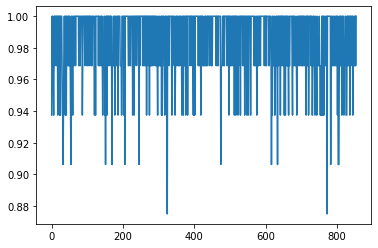

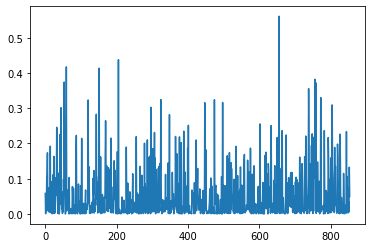

In [0]:
# Batch size 16
for values in [overall_train_loss, overall_train_accuracy, batch_accuracy, batch_loss]:
    plt.plot(values)
    plt.show()

In [0]:
TrainLoader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True, num_workers = 16)
TestLoader = DataLoader(test_data, batch_size=32, shuffle=True, pin_memory=True, num_workers = 16)
overall_train_loss, overall_train_accuracy, batch_loss, batch_accuracy, model = train_model(epochs=50)

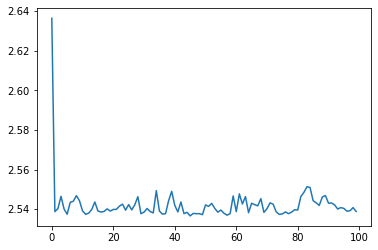

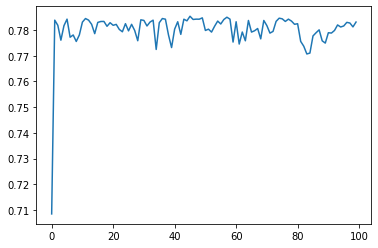

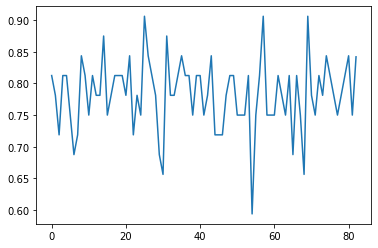

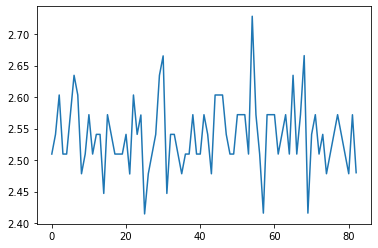

In [0]:
# Batch size 32
for values in [overall_train_loss, overall_train_accuracy, batch_accuracy, batch_loss]:
    plt.plot(values)
    plt.show()

Epoch:200, Batch: 65, Loss:2.4599, Accuracy:0.862: 100%|██████████| 13000/13000 [1:16:24<00:00,  3.38it/s]

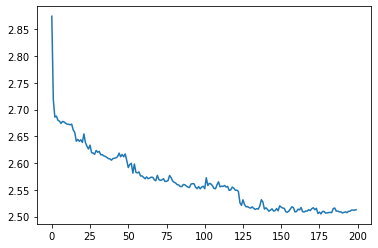

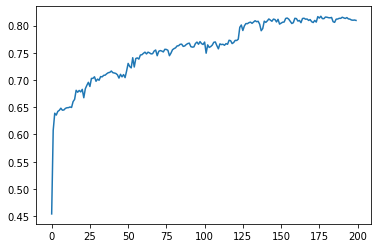

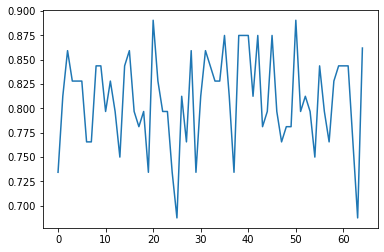

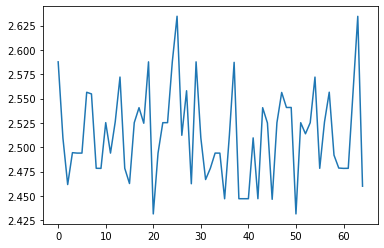

In [0]:
TrainLoader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True, num_workers = 16)
TestLoader = DataLoader(test_data, batch_size=64, shuffle=True, pin_memory=True, num_workers = 16)
overall_train_loss, overall_train_accuracy, batch_loss, batch_accuracy, model = train_model(epochs=200)

# Batch size 64
for values in [overall_train_loss, overall_train_accuracy, batch_accuracy, batch_loss]:
    plt.plot(values)
    plt.show()

In [0]:
overall_train_loss, overall_train_accuracy, batch_loss, batch_accuracy, model = train_model(epochs=50,retrain_model=False, model=model)

Epoch:37, Batch: 1, Loss:2.4939, Accuracy:0.828:  72%|███████▏  | 2340/3250 [13:46<04:31,  3.36it/s] 

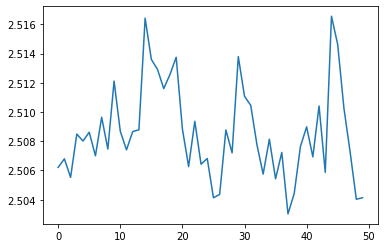

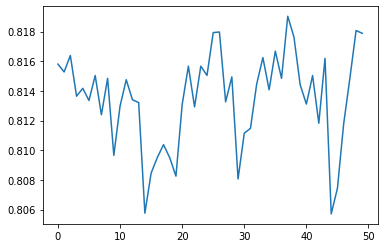

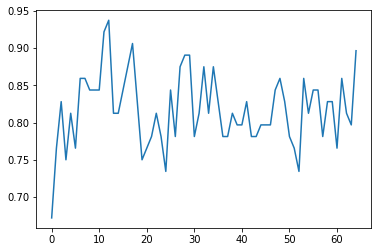

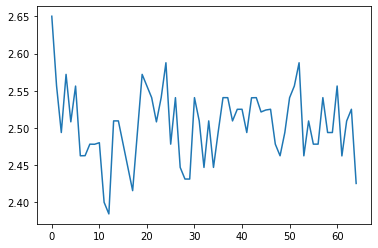

In [0]:
# Batch size 64
for values in [overall_train_loss, overall_train_accuracy, batch_accuracy, batch_loss]:
    plt.plot(values)
    plt.show()

In [0]:
# How to load in the weights for the trained BoggleNet
# weights_filename = './drive/My Drive/BYU/Boggle Project/boggleNet_weights.pth'
# model2 = BoggleNet()
# state_dict = torch.load(weights_filename)
# model2.load_state_dict(state_dict)


In [0]:
# test_loss = []
# test_accuracy = []
# loss_function = nn.CrossEntropyLoss()
# loop = tqdm(range(len(TestLoader)), position=0)
# with torch.no_grad():
#     for i, (x, y_truth), in enumerate(TestLoader):
#         x, y_truth = x.cuda(), y_truth.cuda()
#         # optimizer.zero_grad()
#         y_hat = model(x)

#         # Compute and store the loss of our current network
#         loss = loss_function(y_hat, y_truth)
#         test_loss.append(loss.item())

#         #Compute and store the accuracy of our current network
#         accuracy = (y_hat.argmax(1) == y_truth).float().mean()
#         test_accuracy.append(accuracy.item())

#         loop.set_description('Batch: {}, Loss:{:.4f}, Accuracy:{:.3f}'.format( i+1,  test_loss[-1], test_accuracy[-1]))
#         loop.update(1)

# print(np.mean(test_accuracy))
# plt.plot(test_accuracy)
# plt.show()